In [19]:
import pandas as pd

# Read in data
r_h_tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')
print(r_h_tracks.head())
print('_________________________________________________________________________________________________ \n \n')
# Read in tracks information
tracks_info = pd.read_json('datasets/echonest-metrics.json', precise_float = True)
print(tracks_info.head())
# Merge the relevant columns
r_h_tracks_info = tracks_info.merge(r_h_tracks[['track_id','genre_top']], on = 'track_id')

   track_id  bit_rate  comments        composer         date_created  \
0       135    256000         1             NaN  2008-11-26 01:43:26   
1       136    256000         1             NaN  2008-11-26 01:43:35   
2       151    192000         0             NaN  2008-11-26 01:44:55   
3       152    192000         0             NaN  2008-11-26 01:44:58   
4       153    256000         0  Arc and Sender  2008-11-26 01:45:00   

         date_recorded  duration  favorites genre_top    genres  ...  \
0  2008-11-26 00:00:00       837          0      Rock  [45, 58]  ...   
1  2008-11-26 00:00:00       509          0      Rock  [45, 58]  ...   
2                  NaN       192          0      Rock      [25]  ...   
3                  NaN       193          0      Rock      [25]  ...   
4  2008-11-26 00:00:00       405          5      Rock      [26]  ...   

  information interest  language_code  \
0         NaN     2484             en   
1         NaN     1948             en   
2         N

In [2]:
# Create a correlation matrix to check for features with high correlation, so we don't have reduce feature redundancy
corrltn = r_h_tracks_info.corr()
corrltn.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [ ]:
#No high correlation between features from the above correlation matrix. Hence we are good to go!

In [3]:
#Split to Train Test

# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split

# Create features
features = r_h_tracks_info.drop(['genre_top', 'track_id'], axis=1).values

# Create labels
labels = r_h_tracks_info['genre_top'].values

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 10)

In [4]:
#Preprocess data

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()


# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

In [6]:
# Inline plots
%matplotlib inline

Text(0.5, 0, 'Principal Component')

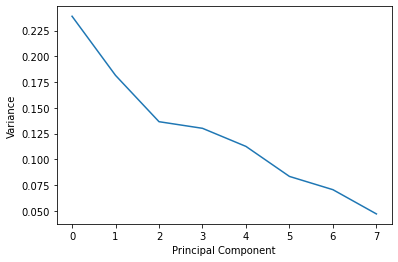

In [7]:
# Import matplotlib, and PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance
fig, ax = plt.subplots()
ax.plot(range(pca.n_components_), exp_variance)
ax.set_ylabel('Variance')
ax.set_xlabel('Principal Component')

Text(0.5, 0, 'Principal Component')

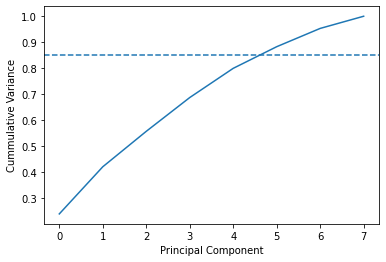

In [8]:
# Import numpy
import numpy as np

# Get cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance using the 85% thumb rule
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')
ax.set_ylabel('Cummulative Variance')
ax.set_xlabel('Principal Component')

In [ ]:
#From the above 85% variance requires about 6 principal components (NB: 0 indexed counting)

In [9]:
# Perform PCA with the 6 components
pca = PCA(n_components = 6, random_state = 10)

# Fit and transform scaled training features using pca
train_rdcd_pca = pca.fit_transform(scaled_train_features)

# Fit and transform scaled test features using pca
test_rdcd_pca = pca.fit_transform(scaled_test_features)

In [10]:
# Import Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Instantiate decision tree
tree = DecisionTreeClassifier(random_state=10)

# Train the decision tree
tree.fit(train_rdcd_pca, train_labels)

# Predict labels using test data
pred_labels_tree = tree.predict(test_rdcd_pca)

In [11]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Instantiate Logistic regression
logreg = LogisticRegression(random_state = 10)

# Train logreg
logreg.fit(train_rdcd_pca, train_labels)

# Predict labels using test data
pred_labels_logreg = logreg.predict(test_rdcd_pca)

# Create classification report for the tree and logreg
from sklearn.metrics import classification_report
clsfctn_rprt_tree = classification_report(test_labels, pred_labels_tree)
clsfctn_rprt_logreg = classification_report(test_labels, pred_labels_logreg)

print("Decision Tree: \n", clsfctn_rprt_tree)
print("Logistic Regression: \n", clsfctn_rprt_logreg)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.52      0.59      0.55       235
        Rock       0.90      0.87      0.88       966

    accuracy                           0.81      1201
   macro avg       0.71      0.73      0.72      1201
weighted avg       0.82      0.81      0.82      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.55      0.63       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.82      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



In [ ]:
#From the above we need to balance our data

In [12]:
# Subset only hip-hop, and rock tracks
# Subset a balanced proportion of data points
hiphop = r_h_tracks_info.loc[r_h_tracks_info['genre_top'] == 'Hip-Hop']
rock = r_h_tracks_info.loc[r_h_tracks_info['genre_top'] == 'Rock']

# choose same sample of rock as hiphop
rock = rock.sample(hiphop.shape[0], random_state=10)

# concatenate hiphop and rock dataframes
blncd_rock_hip = pd.concat([rock, hiphop])

# New features from balanced dataframe
features_b = blncd_rock_hip.drop(['genre_top', 'track_id'], axis=1) 

# New labels from balanced dataframe
labels_b = blncd_rock_hip['genre_top']

# New train-test set from balanced data
train_features_b, test_features_b, train_labels_b, test_labels_b = train_test_split(
    features_b, labels_b, random_state=10)

# Scale new train, and test_features
scaled_train_features_b = scaler.fit_transform(train_features_b)
scaled_test_features_b = scaler.transform(test_features_b)

#Perform PCA on balanced data
train_rdcd_pca_b = pca.fit_transform(scaled_train_features_b)
test_rdcd_pca_b = pca.transform(scaled_test_features_b)

In [13]:
blncd_rock_hip.shape

(1820, 10)

In [14]:
# Instantiate new decision tree
tree_b = DecisionTreeClassifier(random_state=10)

# Train decision tree on the balanced data
tree_b.fit(train_rdcd_pca_b, train_labels_b)

# Predict labels using test data
pred_labels_tree_b = tree_b.predict(test_rdcd_pca_b)

# Instantiate new Logistic regression
logreg_b = LogisticRegression(random_state=10)

# Train logistic regression on the balanced data
logreg_b.fit(train_rdcd_pca_b, train_labels_b)

# Predict labels using test data
pred_labels_logreg_b = logreg_b.predict(test_rdcd_pca_b)

# compare the new models above
print("Decision Tree: \n", classification_report(test_labels_b, pred_labels_tree_b))
print("Logistic Regression: \n", classification_report(test_labels_b, pred_labels_logreg_b))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.82      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



In [ ]:
# For better output we can use Cross Validation!

In [15]:
# Using K-fold cross-validation

#Import Kfold, and cross_val_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
tree_pipeline_b = Pipeline([("scaler_b_cv", StandardScaler()), ("pca_b_cv", PCA(n_components=6)), 
                      ("tree_b_cv", DecisionTreeClassifier(random_state=10))])
logreg_pipeline_b = Pipeline([("scaler_b_cv", StandardScaler()), ("pca_b_cv", PCA(n_components=6)), 
                        ("logreg_b_cv", LogisticRegression(random_state=10))])

# Use K-fold cross-validation
kf_cv = KFold(10)

#Get scores for the models uisng cross validation
tree_b_cv_scores = cross_val_score(tree_pipeline_b, features_b, labels_b, cv=kf_cv)
logreg_b_cv_scores = cross_val_score(logreg_pipeline_b, features_b, labels_b, cv=kf_cv)

# Find the mean score
print("Decision Tree:", np.mean(tree_b_cv_scores), "Logistic Regression:", np.mean(logreg_b_cv_scores))

Decision Tree: 0.7582417582417582 Logistic Regression: 0.782967032967033


In [ ]:
#Logistic Regression is a better model to use!